In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import pickle
import numpy as np
from scipy.misc import imread, imsave
from pathlib import Path

import matplotlib.pyplot as plt
%matplotlib inline

from src.enhancer import ImageComparator
from src.enhancer.enhancers import ENHANCERS
from src.shared import rgb_hue

19.4091194773
-16.6563116187


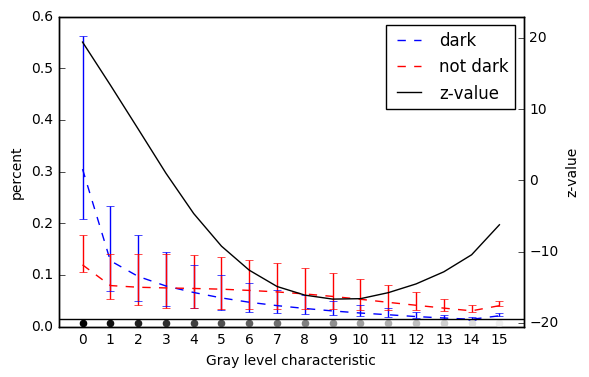

In [10]:
dark_z = 'z-values/dark.pkl'
z_d = pickle.load(open(dark_z, 'rb'))

gd = z_d.descriptors['gray_hist']
plt.xlim([-0.5, 15.5])
plt.xlabel('Gray level characteristic')
plt.xticks(np.arange(16))
plt.tick_params(axis='x', which='both', length=0)

ax = plt.gca()
ax.errorbar(np.arange(16), gd.mean, yerr=[gd.quantiles[1], gd.quantiles[2]], label='dark', ls='--')
ax.errorbar(np.arange(16), gd.nmean, yerr=[gd.nquantiles[1], gd.nquantiles[2]], label='not dark', ls='--', color='red')
ax.set_ylabel('percent')

ax_z = ax.twinx()
lns2 = ax_z.plot(gd.descriptor, label='z-value', color='black')
ax_z.axhline(-19.5, color='black')
ax_z.set_ylim([-20.5, 23])
ax_z.set_ylabel('z-value')

for i in range(16):
    ax_z.scatter(i, -20.0, color=np.array([1, 1, 1]) * i / 16.0)

h1, l1 = ax.get_legend_handles_labels()
h1 = [h[0] for h in h1]
h2, l2 = ax_z.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2)

plt.savefig('dark-z-value.jpg')

print(gd.descriptor.max())
print(gd.descriptor.min())

In [84]:
filename = 'z-values/orchid.pkl'
zcollection = pickle.load(open(filename, 'rb'))

items = ['gray_hist', 'chroma_hist', 'hue_angle_hist', 'rgb_hist', 'lab_hist', 'lch_hist']
string = ''
for i in items:
    string = string + (' & %s' % int(zcollection.descriptors[i].delta_z))
string


' & 8 & 25 & 24 & 32 & 34 & 36'

In [41]:
np.savez('rgb_hue.npz', rgb_hue=rgb_hue)

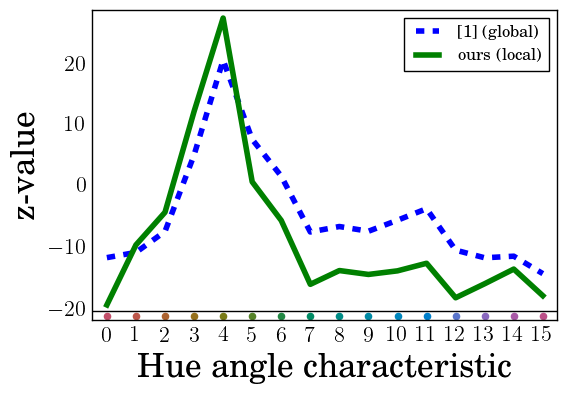

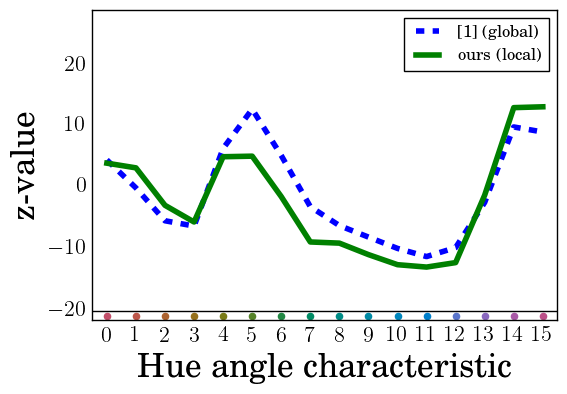

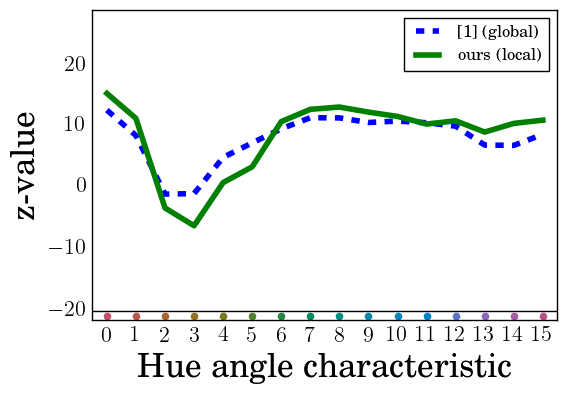

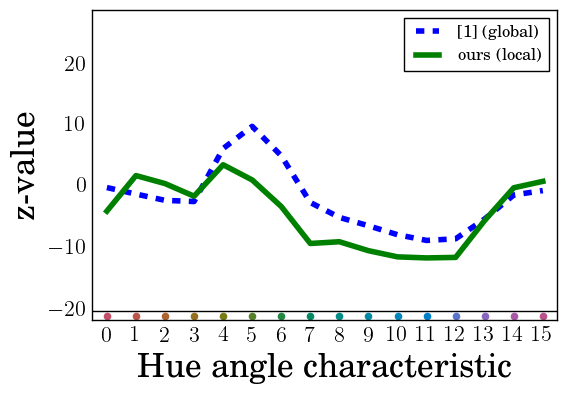

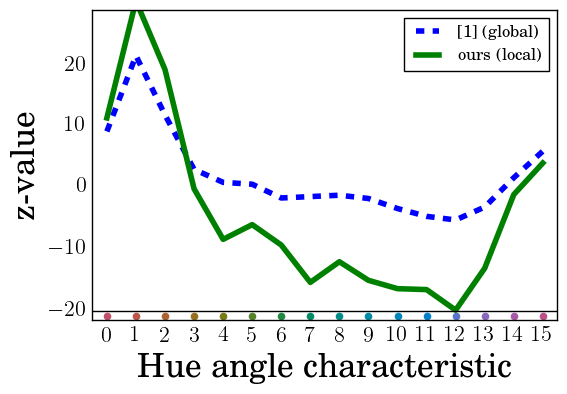

In [40]:
keywords = ['sunflower', 'orchid', 'ferrari', 'lily', 'strawberry']

for keyword in keywords:
    orchid_z = 'z-values/%s.pkl' % keyword
    orchid_zl = 'z-values/%s-local.pkl' % keyword
    z_o = pickle.load(open(orchid_z, 'rb'))
    zl_o = pickle.load(open(orchid_zl, 'rb'))

    plt.rc('text', usetex=True)
    plt.rcParams['font.family'] = 'Helvetica'

    plt.plot(z_o.descriptors['hue_angle_hist'].descriptor, '--', label='[1] (global)', linewidth=4)
    plt.plot(zl_o.descriptors['hue_angle_hist'].descriptor, label='ours (local)', linewidth=4)
    plt.axhline(-20.5, color='black')
    plt.xlim([-0.5, 15.5])
    plt.ylim([-22, 29])
    plt.ylabel('z-value', fontsize=24)
    plt.xlabel('Hue angle characteristic', fontsize=24)
    plt.xticks(np.arange(16))
    plt.tick_params(axis='both', which='both',length=0, labelsize=16)
#     plt.title(r'Concept \textit{%s}' % keyword, fontsize=36, y=1.04)

    for i in range(16):
        plt.scatter(i, -21.3, color=rgb_hue[i, :])
    plt.legend()
    plt.savefig('concept-%s.eps' % keyword, format='eps', dpi=1000, bbox_inches='tight')
    plt.show()
    
    np.savez('%s-comparison.npz' % keyword, global_descriptor=z_o.descriptors['hue_angle_hist'].descriptor,
            local_descriptor=zl_o.descriptors['hue_angle_hist'].descriptor)
    
